In [1]:
import delfi.distribution as dd
import matplotlib.pyplot as plt
import numpy as np
import time
import torch

from delfi.generator import Default
from delfi.simulator import Gauss
from delfi.summarystats import Identity
from helpers import *
from torch.autograd import Variable

%matplotlib inline

In [2]:
N = 25      # size of toy data

m = Gauss(noise_cov=np.sqrt(0.01))
p = dd.Uniform(lower=-2, upper=2)
s = Identity()
g = Default(model=m, prior=p, summary=s)

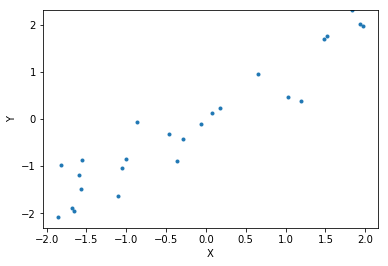

In [3]:
X, Y = g.gen(N, verbose=False);

X_var = Variable(torch.Tensor(X))
Y_var = Variable(torch.Tensor(Y))

plt.plot(X, Y, '.');
plt.xlabel('X');
plt.ylabel('Y');
ylim = max(abs(Y))
plt.ylim(-ylim, ylim);

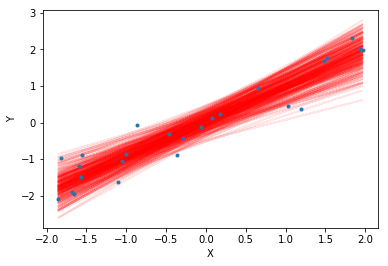

In [4]:
# posterior with bayesian linear regression

alpha = 0.01  # precision of isotropic Gaussian prior on weight
betam = 1.    # precision of model noise

m0 = 0.
S0 = 1/alpha*np.eye(2)
Phi = np.array([X.squeeze(), 
                np.ones((len(X)))]).T

SN = np.linalg.inv(alpha+betam*np.dot(Phi.T, Phi))
mN = betam*np.dot(SN, np.dot(Phi.T, Y))

for r in range(250):
    sampam = np.random.multivariate_normal(mN.squeeze(), SN, 1)
    plt.plot(X, np.dot(sampam.squeeze(), np.array([X, 1])), '-r', alpha=0.1)
plt.plot(X, Y, '.');
plt.xlabel('X');
plt.ylabel('Y');

In [5]:
model = MDN(svi=True, n_samples=100)

tic = time.time()
train(X, Y, model)
print('time elapsed : {:.2f}s'.format(time.time()-tic))

[epoch 0050] loss: 5.0379
[epoch 0100] loss: 4.1986
[epoch 0150] loss: 3.6435
[epoch 0200] loss: 3.3180
[epoch 0250] loss: 2.9885
[epoch 0300] loss: 2.8789
[epoch 0350] loss: 2.4837
[epoch 0400] loss: 2.4607
[epoch 0450] loss: 2.4270
[epoch 0500] loss: 2.5789
time elapsed : 14.04s


In [9]:
# delete again
def al_loss1(x_param, obs, model, prior_mean, prior_var, beta=1., frozen=True):
    # C(θ) = ...
    
    # x_param is θ   
    (out_alpha, out_sigma, out_mu) = model(x_param, frozen=frozen)

    # y_var is x_o
    y_var = Variable(torch.Tensor(obs))
    lp = mdn_logloss(out_alpha, out_sigma, out_mu, y_var)
    
    p = torch.exp(lp).mean()
    H = -p*torch.log(p)
    
    H2 = -(torch.exp(lp)*lp).mean()
    
    C = H  # *prior(theta)
    
    return C, lp

In [6]:
def al_loss(x_param, obs, model, prior_mean, prior_var, beta=1., frozen=True):
    # C(θ) = ...
    
    # x_param is θ   
    (out_alpha, out_sigma, out_mu) = model(x_param, frozen=frozen)

    # y_var is x_o
    y_var = Variable(torch.Tensor(obs))
    lp = mdn_logloss(out_alpha, out_sigma, out_mu, y_var)
    
    p = torch.exp(lp).mean()
    H = -p*torch.log(p)
    
    H2 = -(torch.exp(lp)*lp).mean()
    
    C = H - H2 # *prior(theta)
    
    return C, lp

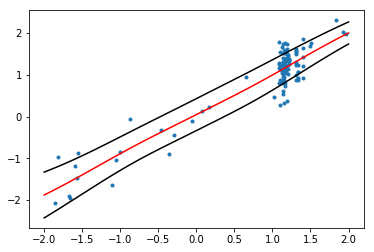

In [15]:
X_lin = np.linspace(-2, 2, 100).reshape(-1,1)
X_var_lin = Variable(torch.Tensor(X_lin))
Y_var = Variable(torch.Tensor(Y))

(out_alpha, out_sigma, out_mu) = model(X_var_lin, sample=False)

plt.plot(X, Y, '.')
plt.plot(X_lin, out_mu.data.numpy(), '-r');
plt.plot(X_lin, out_mu.data.numpy() + out_sigma.data.numpy(), '-k');
plt.plot(X_lin, out_mu.data.numpy() - out_sigma.data.numpy(), '-k');

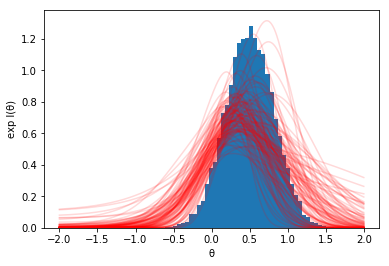

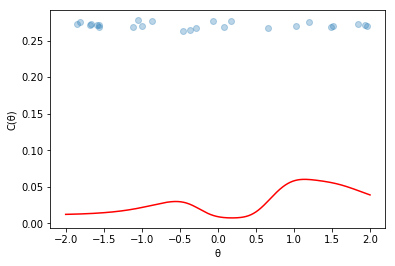

argmax C(θ)=1.142 with β=0.25


In [11]:
thetas = np.linspace(-2., 2.0, 500)

beta = 0.25  # beta in [0,1]. 1=mean, 0=var
prior_mean = 0.
prior_var = 0.
obs = np.array([0.5])

Cs = []
Lps = []

for theta in thetas:   
    x_param = Variable(torch.Tensor(np.array([theta]).astype(np.float32)))
    y_var = Variable(torch.Tensor(obs))
    C, Lp = al_loss(x_param, obs, model, prior_mean, prior_var, beta=beta, frozen=True)
    
    C = C.data.numpy()
    Lp = Lp.data.numpy()
    
    Cs.append(C)
    Lps.append(Lp)
    
samples = 0.5+np.random.randn(20000)*np.sqrt(m.noise_cov[0])
plt.hist(samples, bins=50, density=True);
plt.plot(thetas, np.exp(Lps), '-r', alpha=0.15);
plt.xlabel('θ')
plt.ylabel('exp l(θ)')
plt.show();

XU = np.unique(X)
plt.plot(XU, 0.27*np.ones((len(XU),))+0.005*np.random.randn(len(XU)), 'o', alpha=0.3)
plt.plot(thetas, Cs, '-r');
plt.xlabel('θ')
plt.ylabel('C(θ)')
plt.show();

print('argmax C(θ)={:.3f} with β={}'.format(thetas[np.nanargmax(Cs)], beta))
if np.any(np.isnan(Cs)):
    print('Warning: Cs contain NaNs')

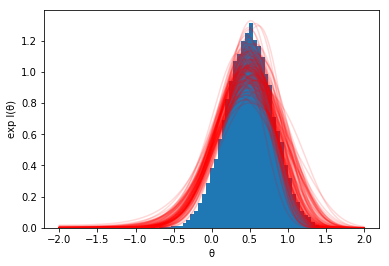

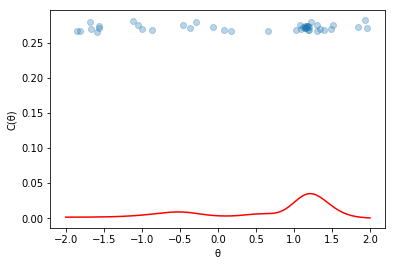

argmax C(θ)=1.214 with β=0.25


In [14]:
thetas = np.linspace(-2., 2.0, 500)

beta = 0.25  # beta in [0,1]. 1=mean, 0=var
prior_mean = 0.
prior_var = 0.
obs = np.array([0.5])

Cs = []
Lps = []

for theta in thetas:   
    x_param = Variable(torch.Tensor(np.array([theta]).astype(np.float32)))
    y_var = Variable(torch.Tensor(obs))
    C, Lp = al_loss(x_param, obs, model, prior_mean, prior_var, beta=beta, frozen=True)
    
    C = C.data.numpy()
    Lp = Lp.data.numpy()
    
    Cs.append(C)
    Lps.append(Lp)
    
samples = 0.5+np.random.randn(20000)*np.sqrt(m.noise_cov[0])
plt.hist(samples, bins=50, density=True);
plt.plot(thetas, np.exp(Lps), '-r', alpha=0.15);
plt.xlabel('θ')
plt.ylabel('exp l(θ)')
plt.show();

XU = np.unique(X)
plt.plot(XU, 0.27*np.ones((len(XU),))+0.005*np.random.randn(len(XU)), 'o', alpha=0.3)
plt.plot(thetas, Cs, '-r');
plt.xlabel('θ')
plt.ylabel('C(θ)')
plt.show();

print('argmax C(θ)={:.3f} with β={}'.format(thetas[np.nanargmax(Cs)], beta))
if np.any(np.isnan(Cs)):
    print('Warning: Cs contain NaNs')

In [12]:
tic = time.time()

t_init = np.array([0.5]).astype(np.float32)
x_param = nn.Parameter(torch.from_numpy(t_init))

optim = torch.optim.Adam([x_param], lr=0.1)

for i in range(100):
    optim.zero_grad()
    C, Lp = al_loss(x_param, obs, model, prior_mean, prior_var, beta=beta, frozen=True)
    C = -1*C
    C.backward()
    optim.step()

t_star = x_param.data.numpy()[0]

print('time elapsed : {:.2f}s'.format(time.time()-tic))
print('θ* = {:.2f}'.format(t_star))

time elapsed : 1.00s
θ* = 1.14


In [ ]:
for i in range(2500):
    t_init = np.array([0.5]).astype(np.float32)
    x_param = nn.Parameter(torch.from_numpy(t_init))
    optim = torch.optim.Adam([x_param], lr=0.1)
    for i in range(100):
        optim.zero_grad()
        C, Lp = al_loss(x_param, obs, model, prior_mean, prior_var, beta=beta, frozen=True)
        C = -1*C
        C.backward()
        optim.step()
    t_star = x_param.data.numpy()[0]
    print('new θ* = {:.2f}'.format(t_star))

    idx = np.arange(0, len(X), 1)
    np.random.shuffle(idx)

    N_REPS = 5
    X_retrain = np.repeat(np.array([[t_star]]), N_REPS, axis=0)
    Y_retrain = s.calc(m.gen([t_star], verbose=False, n_reps=N_REPS)[0])

    X_retrain = np.concatenate((X_retrain, X))
    Y_retrain = np.concatenate((Y_retrain, Y))
    X = X_retrain
    Y = Y_retrain

    #M = N
    #X_retrain = np.concatenate((X_retrain, X[idx[:M], :]))
    #Y_retrain = np.concatenate((Y_retrain, Y[idx[:M], :]))

    tic = time.time()
    train(X_retrain, Y_retrain, model, n_epochs=250)
    print('time elapsed : {:.2f}s'.format(time.time()-tic))

new θ* = 1.22
[epoch 0050] loss: 0.7974
[epoch 0100] loss: 0.7485
[epoch 0150] loss: 1.0571
[epoch 0200] loss: 0.9065
[epoch 0250] loss: 0.4656
time elapsed : 37.73s
new θ* = 1.18
[epoch 0050] loss: 1.3275
[epoch 0100] loss: 0.9151
[epoch 0150] loss: 1.7022
[epoch 0200] loss: 1.2130
[epoch 0250] loss: 1.0910
time elapsed : 38.61s
new θ* = 1.19
[epoch 0050] loss: 0.6883
[epoch 0100] loss: 0.5115
[epoch 0150] loss: 0.8630
[epoch 0200] loss: 0.7697
[epoch 0250] loss: 1.2442
time elapsed : 41.07s
new θ* = 1.22
[epoch 0050] loss: 0.6814
[epoch 0100] loss: 0.4423
[epoch 0150] loss: 0.6955
[epoch 0200] loss: 1.0128
[epoch 0250] loss: 0.7652
time elapsed : 40.31s
new θ* = 1.16
[epoch 0050] loss: 1.1544
[epoch 0100] loss: 0.5797
[epoch 0150] loss: 0.8008
[epoch 0200] loss: 0.8423
[epoch 0250] loss: 0.5794
time elapsed : 44.52s
new θ* = 1.20
[epoch 0050] loss: 0.5202
[epoch 0100] loss: 0.8346
[epoch 0150] loss: 0.9154
[epoch 0200] loss: 0.9771
[epoch 0250] loss: 0.6806
time elapsed : 44.02s
new 

In [ ]:
X_lin = np.linspace(-2, 2, 100).reshape(-1,1)
X_var_lin = Variable(torch.Tensor(X_lin))
Y_var = Variable(torch.Tensor(Y))

(out_alpha, out_sigma, out_mu) = model(X_var_lin, sample=False)

plt.plot(X, Y, '.')
plt.plot(X_lin, out_mu.data.numpy(), '-r');
plt.plot(X_lin, out_mu.data.numpy() + out_sigma.data.numpy(), '-k');
plt.plot(X_lin, out_mu.data.numpy() - out_sigma.data.numpy(), '-k');